In [1]:
include("so5.jl");

using Plots, Interpolations, LaTeXStrings

# fnt = Plots.font("sans-serif")
# default(titlefont=fnt, guidefont=fnt, tickfont=fnt, legendfont=fnt)

Plots.scalefontsizes()
Plots.scalefontsizes(1.5)
pyplot()
# PyPlot.rc("font", family="Times")

using JLD2
using FileIO
;

In [2]:
intlist = [(57,106,177), (218,124,48), (62,150,81), (204,37,41), (83,81,84), (107,76,154), (146,36,40), (148,139,61)]
colorlist = [RGBA(r/255,g/255,b/255,1) for (r,g,b) in intlist]
;

### Read data and make it into `dict(param => table in (ctop_list, af_list))`

In [3]:
address = ""

af_list = load(address*"data_uncolored.jld2", "af_list")
ctop_list = load(address*"data_uncolored.jld2", "ctop_list")
data = load(address*"data_uncolored.jld2")
delete!(data, "af_list")
delete!(data, "ctop_list")
@show length(data)
@show size(data["zR"])
@show keys(data)
;

length(data) = 8
size(data["zR"]) = (129, 41)
keys(data) = ["zR", "minphi", "higgsmass", "ctop", "cT", "aL", "aB", "af"]


In [4]:
# make non-zero elements consecutive in the table by deleting

function make_continuous(data)
    for (label, table) in data
        for i=1:size(table)[2]
            nonzero_idx = findall(!iszero, table[:,i])
            idx_idx = findlast(!iszero, diff(nonzero_idx).-1) # find last non-zero element
            if idx_idx == nothing
                continue
            else
                table[1:nonzero_idx[idx_idx],i] .= 0.
            end
        end
    end
end
;
make_continuous(data)

### Make interpolated data `itp`, in terms of $k_R$

In [5]:
function itp_ctop_kR(data, kR)
    ret = Dict(label => zeros(length(af_list)) for label in keys(data))
    
    # interpolate ctop for the given (kR, af)
    for j=1:length(af_list)
        idx = findall(!iszero, data["ctop"][:,j]) # find indices of nonzero elements
        itp = interpolate(data["zR"][idx,j], BSpline(Cubic(Line(OnGrid()))))
        sitp = scale(itp, range(data["ctop"][idx[1],j],stop=data["ctop"][idx[end],j],length=length(idx)))
        ret["ctop"][j] = nsolve(sitp, 1. /kR ; lower = data["ctop"][idx[1],j], upper = data["ctop"][idx[end],j])
    end
    
    # interpolate other params for the given (ctop, af)
    for label in keys(data)
        if label == "ctop"
            continue
        end
        for j=1:length(af_list)
            if label == "af" && af_list[j] < 1e-6
                continue
            end
            idx = findall(!iszero, data[label][:,j])
            itp = interpolate(data[label][idx,j], BSpline(Cubic(Line(OnGrid()))))
            sitp = scale(itp, range(data["ctop"][idx[1],j],stop=data["ctop"][idx[end],j],length=length(idx)))
            ret[label][j] = sitp(ret["ctop"][j])
        end
    end
    return ret
end
;

In [6]:
kR_list = [1.5, 2., 2.5, 3.]
itp = Dict()
for kR in kR_list
    itp[kR] = itp_ctop_kR(data, kR)
end

In [7]:
@show [1 ./itp[1.5]["zR"]' ; 1 ./itp[2.5]["zR"]' ; 1 ./itp[3]["zR"]'];

[1 ./ ((itp[1.5])["zR"])'; 1 ./ ((itp[2.5])["zR"])'; 1 ./ ((itp[3])["zR"])'] = [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5; 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5; 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0 3.0]


In [8]:
save(address*"itp_uncolored.jld2", 
    "itp", itp,
    "kR_list", kR_list)

### Plot `itp`

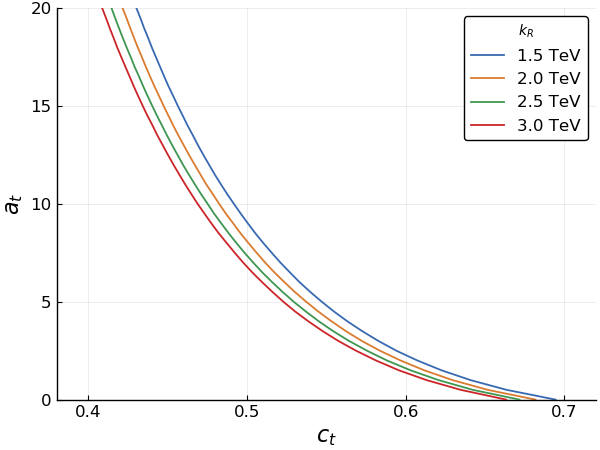

In [9]:
fig = plot(ylim = (0,20), xlim = (0.38, 0.72), 
            xlabel = L"c_{t}", ylabel = L"a_t", 
            legendtitle = L"k_R", size = (600,450)
)
# lcolor = [:red :green :blue :purple]
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["ctop"], itp[kR]["af"], linewidth = 1.3, linecolor = colorlist[i], label = "$kR TeV")
end
fig

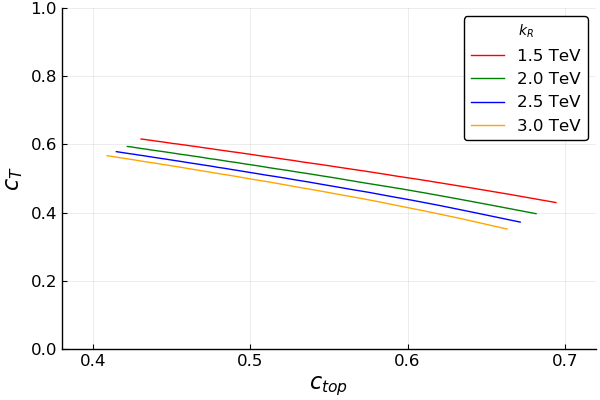

In [10]:
fig = plot(ylim = (0,1), xlim = (0.38, 0.72), xlabel = L"c_{top}", ylabel = L"c_T", legendtitle = L"k_R")
lcolor = [:red :green :blue :orange]
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["ctop"], itp[kR]["cT"], label = "$kR TeV", linecolor = lcolor[i])
end
fig

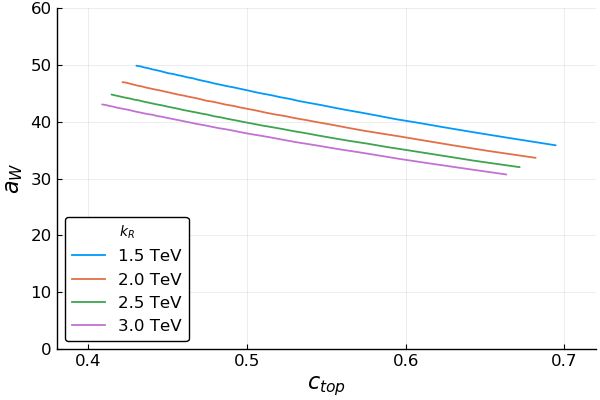

In [11]:
fig = plot(ylim = (0,60), xlim = (0.38, 0.72), xlabel = L"c_{top}", ylabel = L"a_W", legendtitle = L"k_R")
lcolor = [colorlist[4], colorlist[3], colorlist[2], colorlist[1]]
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["ctop"], itp[kR]["aL"].+log(100), label = "$kR TeV", linewidth = 1.3)
end
fig

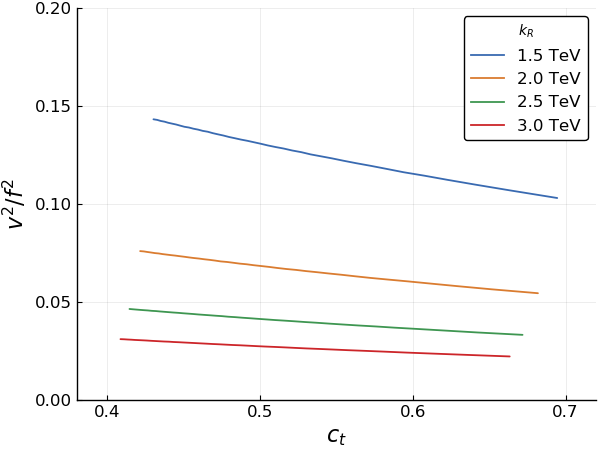

In [12]:
fig = plot(ylim = (0,0.2), xlim = (0.38, 0.72), 
    yticks = (0:0.05:0.2),
    xlabel = L"c_{t}", ylabel = L"v^2/f^2",
    legend = :topright, legendtitle = L"k_R",
    size = (600,450)
)
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["ctop"], sin.(2*itp[kR]["minphi"]).^2, label = "$kR TeV", linecolor = colorlist[i], linewidth = 1.3)
end
fig

In [13]:
pmmass(0., 1. ; n=1)

1-element Array{Float64,1}:
 1.586662880362511

In [14]:
for (i, kR) in enumerate(kR_list)
    itp[kR]["mT"] = [pmmass(cT, 1. /kR ; n=1)[1] for cT in itp[kR]["cT"]]
end

for (i, kR) in enumerate(kR_list)
    itp[kR]["Zkk"] = [ppmass(0.5, 1. /kR ; n=1, af= aL)[1] for aL in itp[kR]["aL"]]
    itp[kR]["Z'"] = [mpmass(0.5, 1. /kR ; n=1)[1] for aL in itp[kR]["aL"]]
end
;

In [15]:
@show [itp[1.5]["Zkk"]'/1.5 ; itp[2]["Zkk"]'/2 ; itp[3]["Zkk"]'/3];
@show [itp[1.5]["Z'"]'/1.5 ; itp[2]["Z'"]'/2 ; itp[3]["Z'"]'/3];

[((itp[1.5])["Zkk"])' / 1.5; ((itp[2])["Zkk"])' / 2; ((itp[3])["Zkk"])' / 3] = [2.43664 2.43671 2.43683 2.43692 2.43704 2.43714 2.43725 2.43738 2.43752 2.4376 2.43774 2.43786 2.43801 2.43812 2.4383 2.43845 2.4386 2.43878 2.43895 2.43913 2.43929 2.43949 2.43969 2.43993 2.44015 2.44036 2.44064 2.44088 2.44121 2.4415 2.44181 2.44219 2.44259 2.443 2.44351 2.44409 2.44468 2.44544 2.44636 2.44752 2.44915; 2.43861 2.43868 2.43881 2.43893 2.43906 2.43915 2.4393 2.43942 2.43955 2.43967 2.43981 2.43995 2.44011 2.44026 2.4404 2.44057 2.44073 2.44092 2.44114 2.44128 2.44149 2.44173 2.44191 2.44217 2.4424 2.44266 2.44296 2.44326 2.44353 2.44389 2.44423 2.44463 2.44504 2.44555 2.4461 2.44666 2.44731 2.44813 2.44914 2.45041 2.4521; 2.4417 2.44179 2.44193 2.44204 2.4422 2.44231 2.44244 2.44257 2.44274 2.4429 2.44305 2.44321 2.44333 2.44354 2.44369 2.44388 2.44407 2.44427 2.44448 2.4447 2.44494 2.44515 2.44541 2.44568 2.44591 2.44621 2.44654 2.44687 2.44719 2.44756 2.44799 2.44844 2.44889 2.44941 2.450

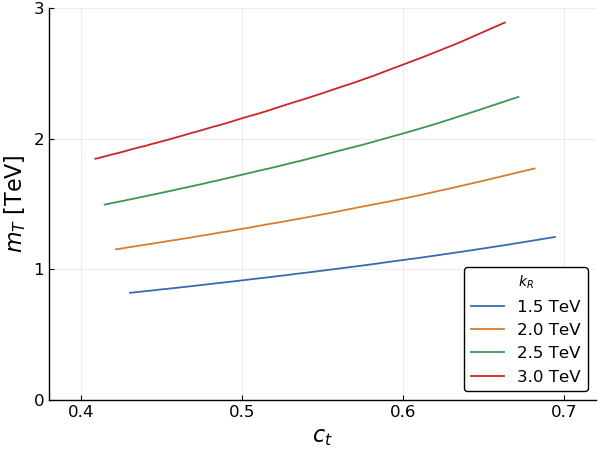

In [16]:
fig = plot(ylim = (0,3), xlim = (0.38, 0.72), 
    xlabel = L"c_{t}", ylabel = L"$m_T$ [TeV]", 
    legendtitle = L"k_R", legend = :bottomright, size = (600,450)
)
lcolor = [:red :green :blue :orange]
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["ctop"],  itp[kR]["mT"], label = "$kR TeV", linecolor = colorlist[i], linewidth = 1.3)
end
fig

In [17]:
itp[1.5]["mT"][1]

0.8183605988867284

In [18]:
for (i, kR) in enumerate(kR_list)
    itp[kR]["mT"] = [pmmass(cT, 1. /kR ; n=1)[1] for cT in itp[kR]["cT"]]
    itp[kR]["mtkk"] = [ppmass(ctop, 1. /kR ; n=1, af = af_list[idx])[1] for (idx, ctop) in enumerate(itp[kR]["ctop"])]
    itp[kR]["mZkk"] = [ppmass(0.5, 1. /kR ; n=1, af = itp[kR]["aL"][idx])[1] for (idx, ctop) in enumerate(itp[kR]["ctop"])]
    # note, for small aL, ppmass > mpmass and for large aL, ppmass -> mpmass so ppmass > mpmass always
    # but, mp boson almost invisible as minus bc in UV and light flavors are UV localized
end
;

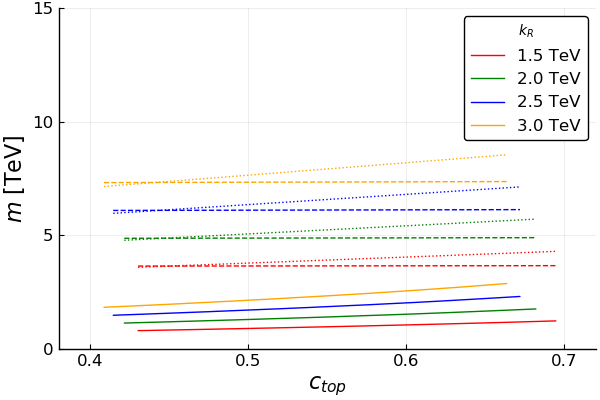

In [19]:
fig = plot(ylim = (0,15), xlim = (0.38, 0.72), xlabel = L"c_{top}", ylabel = L"$m$ [TeV]", legendtitle = L"k_R")
lcolor = [:red :green :blue :orange]
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["ctop"], itp[kR]["mT"],   label = "", linecolor = lcolor[i], linestyle = :solid)
    plot!(fig, itp[kR]["ctop"], itp[kR]["mtkk"], label = "", linecolor = lcolor[i], linestyle = :dot)
    plot!(fig, itp[kR]["ctop"], itp[kR]["mZkk"], label = "", linecolor = lcolor[i], linestyle = :dash)
    plot!(fig, itp[kR]["ctop"], 30 .*ones(size(itp[kR]["ctop"])), label = "$kR TeV", linecolor = lcolor[i], linestyle = :solid)
end

annotate!(fig, 0.75, 2,   L"m_T" )
annotate!(fig, 0.75, 7.2, L"m_{Z_{KK}}" )
annotate!(fig, 0.75, 8.6, L"m_{t_{KK}}" )

fig

### Find the line of phase transition

#### for fixed `aL = 40` and `af = 10`

In [20]:
function ctop_of_phase_transition(arg::Params)
    function total_A(ctop::Float64)
        arg.ctop = ctop
        attractive = -2*3*approx_A(arg, top_denom) + 3*approx_A(arg, W_denom) + 3/2*approx_A(arg, Z_denom)
        repulsive = 2*approx_A(arg, repulsive_denom)
        return attractive + repulsive
    end
    return nsolve(total_A, 0. ; lower = 0., upper = 1.)
end
;

In [21]:
arg = Params(0.,0.,0.,0.,0.,0.,0.,0.,0.,false)
arg.aL = 40.
arg.aB = arg.aL
arg.af = 10.
cT_range = range(0.,stop=0.999,length=30)
ctop_range = zeros(size(cT_range))

for (idx, cT) in enumerate(cT_range)
    arg.cvar = cT
    ctop_range[idx] = ctop_of_phase_transition(arg)
end
;

In [22]:
ctop_range = [ctop_range ; range(ctop_range[end],stop=1.,length=10)]
cT_range = [cT_range ; range(cT_range[end]+0.1,stop=cT_range[end]+0.1,length=10)]
;

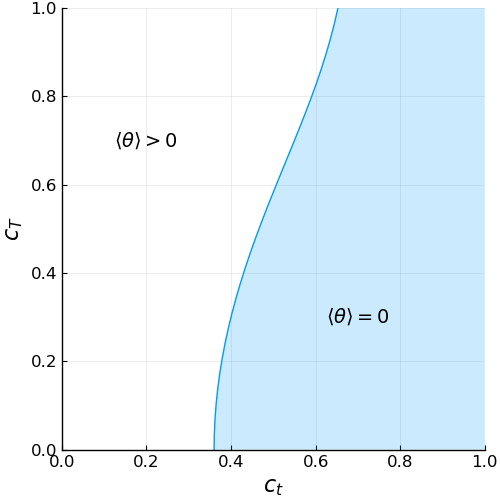

In [23]:
fig = plot(ylim = (0,1), xlim = (0, 1), xlabel = L"c_t", ylabel = L"c_T", size = (500,500))
plot!(fig, ctop_range, cT_range,
    fillrange = 0, fillalpha = 0.2, label="")
annotate!(0.7,0.3,L"\langle \theta \rangle = 0")
annotate!(0.2,0.7,L"\langle \theta \rangle> 0")
# plot!(fig, cT_range, cT_range)
fig

#### for fixed $v^2/f^2$

In [24]:
function cT_of_phase_transition(arg::Params)
    function total_A(cT::Float64)
        arg.cvar = cT
        attractive = -2*3*approx_A(arg, top_denom) + 3*approx_A(arg, W_denom) + 3/2*approx_A(arg, Z_denom)
        repulsive = 2*approx_A(arg, repulsive_denom)
        return attractive + repulsive
    end
    return nsolve(total_A, 0. ; lower = 0., upper = 1.)
end
;

In [25]:
aL_from_kR_minphi(kR, minphi) = 0.5*sin(2*minphi)^2*(2/(1-zratio^2))/(mw^2/kR^2) - kpir

function af_from_kR_minphi(c, kR, minphi) 
    plus_factor  = abs(c+0.5) < 1e-4 ? kpir : f(1+2*c)/(1+2*c)
    minus_factor = abs(c-0.5) < 1e-4 ? kpir : f(1-2*c)/(1-2*c)
    return ( 0.5*sin(2*minphi)^2 / plus_factor /(mt^2/kR^2) - minus_factor ) / zratio^(1-2*c)
end

minphi_from_v2f2(tuning) = asin(sqrt(tuning))/2
;

In [26]:
kR = 3.
v2f2 = 0.03

arg = Params(0.,0.,0.,0.,0.,0.,0.,0.,0.,false)
arg.minphi = minphi_from_v2f2(v2f2)
arg.zR = 1/kR
arg.aL = aL_from_kR_minphi(kR, arg.minphi)
arg.aB = arg.aL
ctop_range = range(0.,stop=0.8,length=30)
cT_range = zeros(size(ctop_range))

for (idx, ctop) in enumerate(ctop_range)
    arg.ctop = ctop
    arg.af = af_from_kR_minphi(arg.ctop, 1/arg.zR, arg.minphi)
    cT_range[idx] = cT_of_phase_transition(arg)
end
;

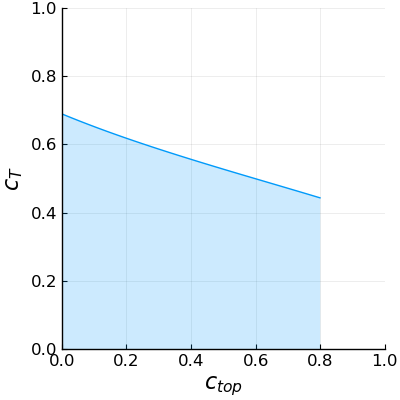

In [27]:
fig = plot(ylim = (0,1), xlim = (0, 1), xlabel = L"c_{top}", ylabel = L"c_T", size = (400,400))
plot!(fig, ctop_range, cT_range,
    fillrange = 0, fillalpha = 0.2, label="")
# annotate!(0.7,0.3,L"<\theta> = 0")
# annotate!(0.2,0.7,L"<\theta> > 0")
# plot!(fig, cT_range, cT_range)
fig

#### from the `data`

In [28]:
function cT_of_phase_transition(arg::Params)
    function total_A(cT::Float64)
        arg.cvar = cT
        attractive = -2*3*approx_A(arg, top_denom) + 3*approx_A(arg, W_denom) + 3/2*approx_A(arg, Z_denom)
        repulsive = 2*approx_A(arg, repulsive_denom)
        return attractive + repulsive
    end
    return nsolve(total_A, 0. ; lower = 0., upper = 1.)
end
;

In [29]:
# helper function to map from itp to Params

function dict_to_Params(dict, idx)
    arg = Params(0.,0.,0.,0.,0.,0.,0.,0.,0.,false)
    arg.aL     = dict["aL"][idx]
    arg.aB     = dict["aB"][idx]
    arg.af     = dict["af"][idx]
    arg.zR     = dict["zR"][idx]
    arg.mh     = dict["higgsmass"][idx]
    arg.ctop   = dict["ctop"][idx]
    arg.cvar   = dict["cT"][idx]
    arg.minphi = dict["minphi"][idx]
    return arg
end
;  

In [30]:
for kR in kR_list
    cT = zeros(size(af_list))
    for idx = 1:length(cT)
        arg = dict_to_Params(itp[kR], idx)
        cT[idx] = cT_of_phase_transition(arg)
    end
    itp[kR]["criticalcT"] = cT 
end
;

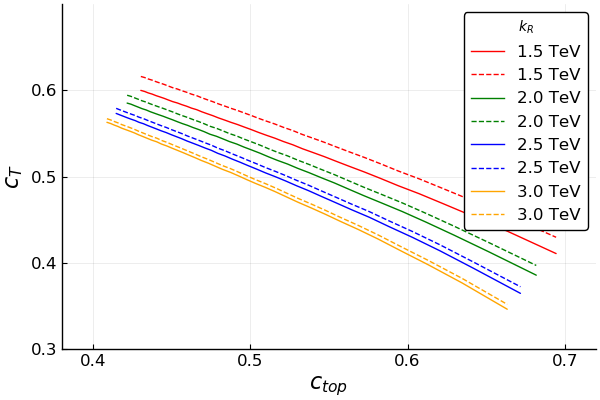

In [31]:
fig = plot(ylim = (0.3,0.7), xlim = (0.38, 0.72), xlabel = L"c_{top}", ylabel = L"c_T", legendtitle = L"k_R")
lcolor = [:red :green :blue :orange]
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["ctop"],  itp[kR]["criticalcT"], label = "$kR TeV", linecolor = lcolor[i])
    plot!(fig, itp[kR]["ctop"],  itp[kR]["cT"], label = "$kR TeV", linecolor = lcolor[i], linestyle = :dash)
end
fig

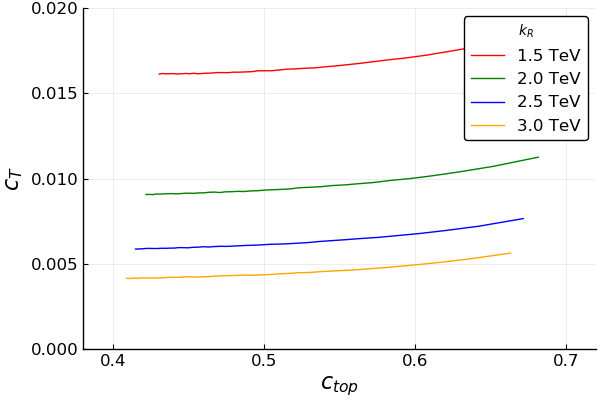

In [32]:
fig = plot(ylim = (0.,0.02), xlim = (0.38, 0.72), xlabel = L"c_{top}", ylabel = L"c_T", legendtitle = L"k_R")
lcolor = [:red :green :blue :orange]
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["ctop"],  itp[kR]["cT"] - itp[kR]["criticalcT"], label = "$kR TeV", linecolor = lcolor[i])
end
fig

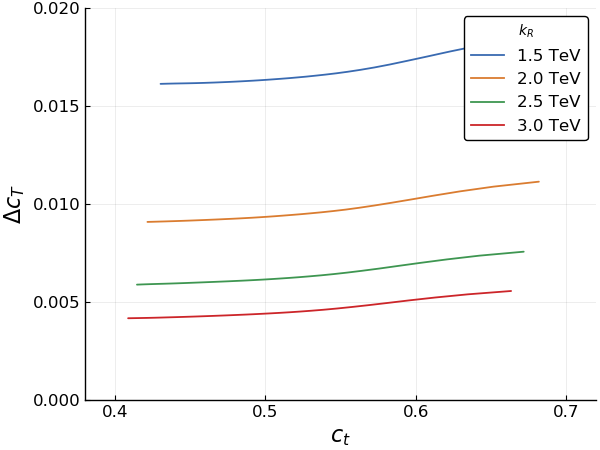

In [33]:
fig = plot(ylim = (0.,0.02), xlim = (0.38, 0.72), 
    xlabel = L"c_{t}", ylabel = L"\Delta c_T", 
    legend = :topright, 
    legendtitle = L"k_R", size = (600,450))
lcolor = [:red :green :blue :orange]
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["ctop"],  smooth(itp[kR]["cT"] - itp[kR]["criticalcT"]; win_len = 19), label = "$kR TeV", linecolor = colorlist[i], linewidth = 1.3)
#     plot!(fig, itp[kR]["ctop"],  itp[kR]["cT"] - itp[kR]["criticalcT"], label = "$kR TeV", linecolor = lcolor[i], linestyle = :dot)
end
# fig.o[:legend](bbox_to_anchor=(1.05, 1), loc=2)
fig

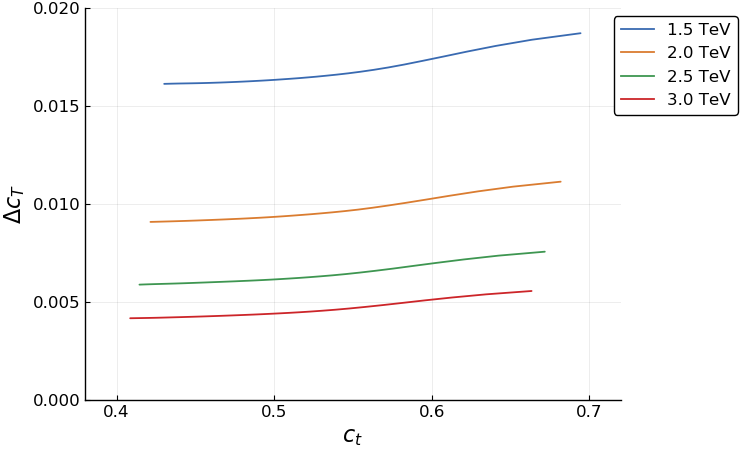

In [34]:
l = @layout [b c{0.18w}]

fig1 = plot(ylim = (0.,0.02), xlim = (0.38, 0.72), 
    xlabel = L"c_{t}", ylabel = L"\Delta c_T", 
    size = (600,450), legend = :none)
fig2 = plot(grid = false, xlims=(100,1), showaxis=false)

lcolor = [:red :green :blue :orange]
for (i, kR) in enumerate(kR_list)
    plot!(fig1, itp[kR]["ctop"],  smooth(itp[kR]["cT"] - itp[kR]["criticalcT"]; win_len = 19), label = "$kR TeV", linecolor = colorlist[i], linewidth = 1.3)
    plot!(fig2, itp[kR]["ctop"],  smooth(itp[kR]["cT"] - itp[kR]["criticalcT"]; win_len = 19), label = "$kR TeV", linecolor = colorlist[i], linewidth = 1.3)
end

fig = plot(fig1, fig2, layout=l)
plot!(fig, size=(750,450))
fig

### Plot in terms of $m_T$ instead of $c_{top}$

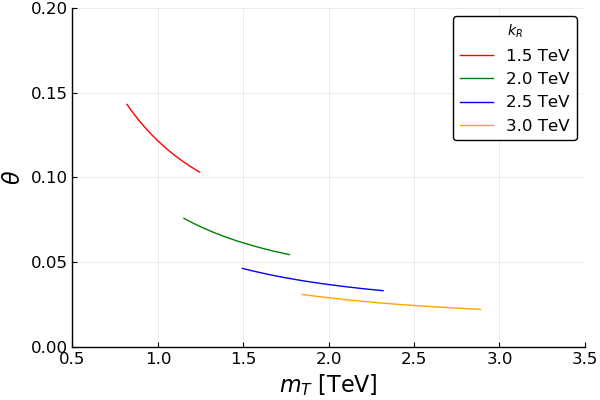

In [35]:
fig = plot(ylim = (0,0.2), xlim = (0.5, 3.5), xlabel = L"$m_T$ [TeV]", ylabel = L"\theta", legendtitle = L"k_R")
lcolor = [:red :green :blue :orange]
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["mT"], sin.(2*itp[kR]["minphi"]).^2, label = "$kR TeV", linecolor = lcolor[i])
end
fig

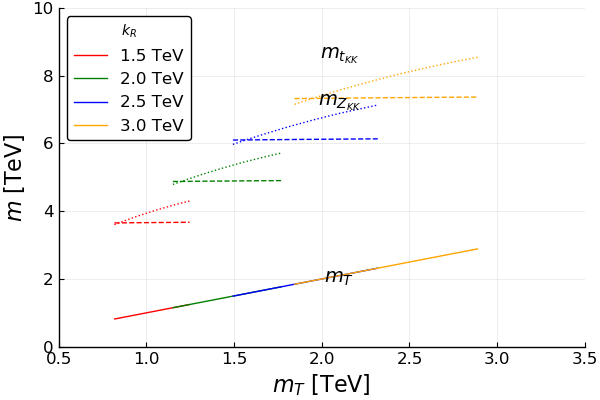

In [36]:
fig = plot(ylim = (0,10), xlim = (0.5, 3.5), xlabel = L"$m_T$ [TeV]", ylabel = L"$m$ [TeV]", legendtitle = L"k_R")
lcolor = [:red :green :blue :orange]
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["mT"], itp[kR]["mT"],   label = "", linecolor = lcolor[i], linestyle = :solid)
    plot!(fig, itp[kR]["mT"], itp[kR]["mtkk"], label = "", linecolor = lcolor[i], linestyle = :dot)
    plot!(fig, itp[kR]["mT"], itp[kR]["mZkk"], label = "", linecolor = lcolor[i], linestyle = :dash)
    plot!(fig, itp[kR]["mT"], 30 .*ones(size(itp[kR]["ctop"])), label = "$kR TeV", linecolor = lcolor[i], linestyle = :solid)
end

annotate!(fig, 2.1, 2,   L"m_T" )
annotate!(fig, 2.1, 7.2, L"m_{Z_{KK}}" )
annotate!(fig, 2.1, 8.6, L"m_{t_{KK}}" )

fig

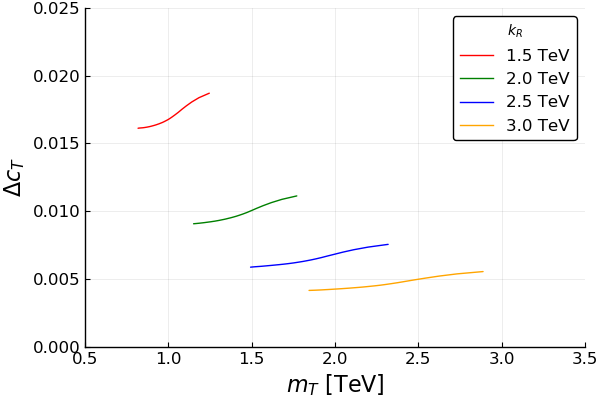

In [37]:
fig = plot(ylim = (0.,0.025), xlim = (0.5, 3.5), xlabel = L"$m_T$ [TeV]", ylabel = L"\Delta c_T", legendtitle = L"k_R")
lcolor = [:red :green :blue :orange]
for (i, kR) in enumerate(kR_list)
    plot!(fig, itp[kR]["mT"],  smooth(itp[kR]["cT"] - itp[kR]["criticalcT"]; win_len = 19), label = "$kR TeV", linecolor = lcolor[i])
#     plot!(fig, itp[kR]["ctop"],  itp[kR]["cT"] - itp[kR]["criticalcT"], label = "$kR TeV", linecolor = lcolor[i], linestyle = :dot)
end
fig

##### 

### S and T Parameters

In [38]:
pi*vev^2/1.5^2*(3/2 - 1 /(log(1/zratio)+40))

0.12485009827547928

In [39]:
slimit=0.135
sqrt.(pi*vev^2/slimit*(3/2 .- 1 ./(log(1/zratio).+[0,30,40,50,1e8])))

5-element Array{Float64,1}:
 1.3440999517022627
 1.439344121319998 
 1.4425099553410325
 1.444512661191908 
 1.4534121528978161

In [40]:
function update_c(c)
    window = 0.00009 
    shift  = 0.0001
    if abs(c-0.5) < window || abs(c-1.5) < window || abs(c+0.5) < window || abs(c+1.5) < window
        return c + shift
    else
        return c
    end
end

function zmoment(b, c, a) 
    c = update_c(c)
    numerator =  (1-zratio^(1+b-2*c))/(1+b-2*c)+a*zratio^(1+b-2*c) 
    denominator =  (1-zratio^(1-2*c))/(1-2*c) + a*zratio^(1-2*c) 
    return numerator/denominator
end

function Zpm(c,a)
    c = update_c(c)
    return 1/(4*c+2) - 1/(4*c-2)*zmoment(2,c,a) + 1/(4*c^2-1)*zmoment(1+2*c,c,a)
end

Zpm0(c,a) = 1/(4*c+2)

Zpp0(c,a) = 1/(4*c+6)

function Lt(c,a)
    c = update_c(c)
    return (zratio^(1/2-c)-zratio^(c-1/2))/(c*2-1) + a*zratio^(1/2-c)
end

function Ztmm(c,a)
    c = update_c(c)
    return 1/2/Lt(c,a)* ( zratio^(1/2-c)/(4*c^2-1) + zratio^(c-1/2)/(2*c-1)/(2*c-3) + a*zratio^(1/2-c)/(2*c+1) )
end

loopT(c,a) = 2*(2*Zpm(c,a)-Zpm0(c,a)-Zpp0(c,a)-2*Ztmm(c,a) + Lt(c,a)/(2*c+1)*zratio^(1/2-c)*(2*zmoment(1+2*c,c,a)))
;    

In [41]:
for kR in kR_list
    itp[kR]["S"] = pi*vev^2/kR^2*(3/2 .- 1 ./(log(1/zratio).+itp[kR]["aB"]))
    itp[kR]["T"] = pi*vev^2/kR^2/4/c2*( 1 ./(log(1/zratio).+itp[kR]["aL"]) .- 1 ./(log(1/zratio).+itp[kR]["aB"]))
    prefactor = 3/16/pi*mt0^2/(s2*c2*mz^2)
    tempforloop = [loopT(c,a) for (c,a) in zip(itp[kR]["ctop"],itp[kR]["af"])]
    lowkR = kR;
    highkR = 100*kR;
    itp[kR]["loopTlow"] = prefactor*tempforloop*mt0^2/kR^2*log(lowkR^2/mt0^2)
    itp[kR]["loopThigh"] = prefactor*tempforloop*mt0^2/kR^2*log(highkR^2/mt0^2)    
end
;

In [42]:
splot = zeros(size(kR_list))
lowT = zeros(size(kR_list))
highT = zeros(size(kR_list))
for (i, kR) in enumerate(kR_list)
    splot[i] = (itp[kR]["S"][1] + itp[kR]["S"][end])/2.
    lowT[i] = minimum(itp[kR]["loopTlow"])
    highT[i] = maximum(itp[kR]["loopThigh"])
end
;

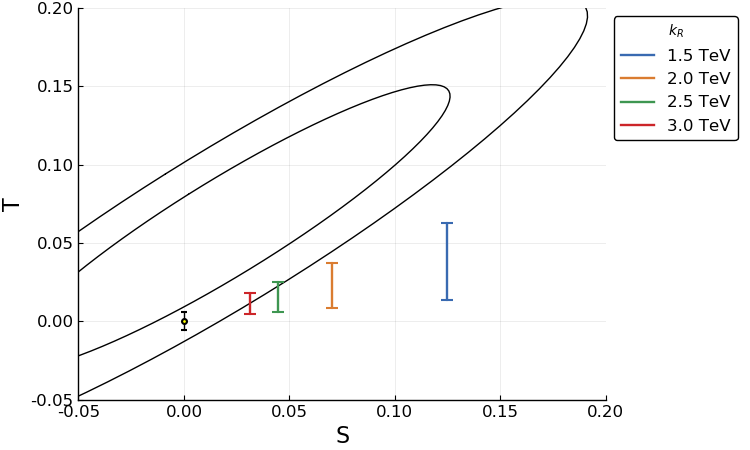

In [43]:
l = @layout [b c{0.18w}]

fig1 = plot(ylim = (-0.05,0.2), xlim = (-0.05, 0.2), xlabel = "S", ylabel = "T", size = (600,450), legend = :none)
fig2 = plot(grid = false, xlims=(100,1), showaxis=false, legendtitle = L"k_R")
scatter!(fig1, [0.],[0.], yerror=deltaT, markersize=4, color = :black, label="")
scatter!(fig1, [0.],[0.], markersize=3, color = :yellow, label="")
plot!(fig1, ss68, tt68, color=:black, label="")
plot!(fig1, ss95, tt95, color=:black, label="")
for (i, kR) in enumerate(kR_list)
    plot!(fig1, [splot[i] for x in 1:101], [lowT[i] + (x-1)/100*(highT[i]-lowT[i]) for x in 1:101],
        linewidth = 1.7, color = colorlist[i], label="$kR TeV")
    plot!(fig2, [splot[i] for x in 1:101], [lowT[i] + (x-1)/100*(highT[i]-lowT[i]) for x in 1:101],
        linewidth = 1.7, color = colorlist[i], label="$kR TeV")
    scatter!(fig1, [splot[i]], [lowT[i]], m = (8,:hline), color = colorlist[i], label="" )
    scatter!(fig1, [splot[i]], [highT[i]], m = (8,:hline), color = colorlist[i], label="" )
end
fig = plot(fig1, fig2, layout=l)
plot!(fig, size=(750,450))
fig

In [44]:

# TS contour
# PDG values
scenter = 0.02 
sigmas = 0.07
tcenter = 0.06
sigmat = 0.06
corr = 0.92



convmat = [sigmas^2 corr*sigmas*sigmat ; corr*sigmas*sigmat sigmat^2]
major = max(sqrt.(eigvals(convmat))[1],sqrt.(eigvals(convmat))[2])
minor = min(sqrt.(eigvals(convmat))[1],sqrt.(eigvals(convmat))[2])
theta = 0.5*atan(2*corr*sigmas*sigmat/(sigmas^2-sigmat^2))
p68 = sqrt(2.3)
p95 = sqrt(5.991)
t = collect(range(0, step=2*pi/100, length=101))
s68 = major*p68*sin.(t)
t68 = minor*p68*cos.(t)
ss68 = scenter.+([cos(theta) -sin(theta) ; sin(theta) cos(theta)]*[s68' ; t68'])[1,:]
tt68 = tcenter.+([cos(theta) -sin(theta) ; sin(theta) cos(theta)]*[s68' ; t68'])[2,:]

s95 = major*p95*sin.(t)
t95 = minor*p95*cos.(t)
ss95 = scenter.+([cos(theta) -sin(theta) ; sin(theta) cos(theta)]*[s95' ; t95'])[1,:]
tt95 = tcenter.+([cos(theta) -sin(theta) ; sin(theta) cos(theta)]*[s95' ; t95'])[2,:]

mt0 = 0.173
dmt = 0.4
s2 = gy^2/(g^2+gy^2)
c2 = 1-s2
deltaT = 3/8/pi*mt0*dmt/1000/(s2*c2*mz^2)
# Sdmt = zeros(100)
# Tdmt = linspace(-deltaT, +deltaT, 100)
Terr = [-deltaT deltaT]


1×2 Array{Float64,2}:
 -0.00573464  0.00573464

In [45]:
major

0.09037859222803449

In [46]:
sigmas

0.07

In [47]:
theta

0.702068601634361

In [48]:
major*cos(theta)*p95+scenter

0.1888996617012767

In [49]:
maximum(ss95)

0.19130249770493546

In [50]:
maximum(s95)

0.22121533624351167

In [51]:
0.07*p95+scenter

0.19133563552279487